In [1]:
import pandas as pd
import sklearn
from sklearn import preprocessing
import numpy as np
import string
import markov_lyr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from math import ceil

In [2]:
cleaned_lyrics = pd.read_csv('cleaned_lyrics.csv')
cleaned_lyrics = cleaned_lyrics.dropna()

/Users/nicolaireeve/miniconda2/envs/skbiodev/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cleaned_lyrics

,Unnamed: 0,index,song,year,artist,genre,lyrics
0,0,0.0,ego-remix,2009.0,beyonce-knowles,Pop,oh baby how you doing you know i m gonna cut...
1,1,1.0,then-tell-me,2009.0,beyonce-knowles,Pop,playin everything so easy it s like you seem...
2,2,2.0,honesty,2009.0,beyonce-knowles,Pop,if you search for tenderness it isn t hard to ...
3,3,3.0,you-are-my-rock,2009.0,beyonce-knowles,Pop,oh oh oh i oh oh oh i 1 if i wrote book ...
4,4,4.0,black-culture,2009.0,beyonce-knowles,Pop,party people people party it s popping no sit...
5,5,5.0,all-i-could-do-was-cry,2009.0,beyonce-knowles,Pop,i heard church bells ringing i heard choir sin...
6,6,6.0,once-in-a-lifetime,2009.0,beyonce-knowles,Pop,this just another day that i would spend waiti...
7,7,7.0,waiting,2009.0,beyonce-knowles,Pop,waiting waiting waiting waiting waiting wa...
8,8,8.0,slow-love,2009.0,beyonce-knowles,Pop,1 i read all magazines while waiting arou...
9,9,9.0,why-don-t-you-love-me,2009.0,beyonce-knowles,Pop,n n now honey you better sit down and look ar...


In [4]:
articles = set(['a', 'of', 'the', 'an', '\n', 'is', 'verse', 'chorus'])
larticles = [' a ', ' of ', ' the ', ' an ', '\n', ' is ', 'verse', 'chorus']

In [5]:
for i in range (len(string.punctuation)):
    articles.add(string.punctuation[i])
    
for i in range(len(string.punctuation)):
    larticles.append(string.punctuation[i])

In [6]:
#this function was for normalizing the lyrics but I wrote them to cleaned_lyrics.csv so it is no longer needed
def normalize(row):
    row['lyrics'] = row['lyrics'].lower()
    for lar in larticles:
        row['lyrics'] = row['lyrics'].replace(lar, ' ')
    return row['lyrics']

In [7]:
#smallyrics['lyrics'] = smallyrics.apply(normalize, reduce=False, axis=1)

In [8]:
#lyrics['lyrics'] = lyrics.apply(normalize, reduce=False, axis=1)

In [9]:
cleaned_lyrics['genre'].value_counts()

Rock             109235
Pop               40466
Hip-Hop           24850
Not Available     23941
Metal             23759
Country           14387
Jazz               7970
Electronic         7966
Other              5189
R&B                3401
Indie              3149
Folk               2243
Name: genre, dtype: int64

In [10]:
rock_lyrics = cleaned_lyrics.loc[cleaned_lyrics['genre']=='Rock']
metal_lyrics = cleaned_lyrics.loc[cleaned_lyrics['genre']=='Metal']
pop_lyrics = cleaned_lyrics.loc[cleaned_lyrics['genre']=='Pop']
hiphop_lyrics = cleaned_lyrics.loc[cleaned_lyrics['genre']=='Hip-Hop']
country_lyrics = cleaned_lyrics.loc[cleaned_lyrics['genre']=='Country']
jazz_lyrics = cleaned_lyrics.loc[cleaned_lyrics['genre']=='Jazz']

rock_lyrics.reset_index(inplace=True)
metal_lyrics.reset_index(inplace=True)
pop_lyrics.reset_index(inplace=True)
hiphop_lyrics.reset_index(inplace=True)
country_lyrics.reset_index(inplace=True)
jazz_lyrics.reset_index(inplace=True)

Set up training and test sets. I know with neural nets you use a validation set to not
overfit the data or something, but I am not sure how that works or how it applies to 
markov models. But a rule of thumb is that you train on 70% of the data, validate on 20%
and test on 10%. Here I am randomly sampling those percentages from each dataframe so I expect
there to be some overlap. I might fix this so that theres no overlap 

In [11]:
#to fix overlap look at sklearn train_test_split
jazz_train, jazz_test = train_test_split(jazz_lyrics, train_size=0.8, test_size=0.1)
rock_train, rock_test = train_test_split(rock_lyrics, train_size=0.8, test_size=0.1)
metal_train, metal_test = train_test_split(metal_lyrics, train_size=0.8, test_size=0.1)
pop_train, pop_test = train_test_split(pop_lyrics, train_size=0.8, test_size=0.1)
hiphop_train, hiphop_test = train_test_split(hiphop_lyrics, train_size=0.8, test_size=0.1)
country_train, country_test = train_test_split(country_lyrics, train_size=0.8, test_size=0.1)

training_set = [jazz_train, rock_train, metal_train, pop_train, hiphop_train, country_train]
test_set = [jazz_test, rock_test, metal_test, pop_test, hiphop_test, country_test]

for s in training_set:
    s.reset_index(drop=True, inplace=True)
for s in test_set:
    s.reset_index(drop=True, inplace=True)
train_dict = {'Jazz': jazz_train, 'Rock': rock_train, 'Metal':metal_train, 
              'Pop':pop_train, 'Hiphop':hiphop_train, 'Country': country_train}
test_dict = {'Jazz': jazz_test, 'Rock': rock_test, 'Metal':metal_test, 
              'Pop':pop_test, 'Hiphop':hiphop_test, 'Country': country_test}

# concatenate dataframes to exclude only 1 genre

In [12]:
not_jazz = pd.concat([rock_train, metal_train, pop_train, hiphop_train, country_train], ignore_index=True)
not_rock = pd.concat([jazz_train, metal_train, pop_train, hiphop_train, country_train], ignore_index=True)
not_metal = pd.concat([rock_train, jazz_train, pop_train, hiphop_train, country_train], ignore_index=True)
not_pop = pd.concat([rock_train, metal_train, jazz_train, hiphop_train, country_train], ignore_index=True)
not_country = pd.concat([rock_train, metal_train, jazz_train, hiphop_train, pop_train], ignore_index=True)
not_hiphop = pd.concat([rock_train, metal_train, jazz_train, pop_train, country_train], ignore_index=True)

test_df = pd.concat(test_set, ignore_index=True)

In [13]:
def avg_song_len(songs):
    num_songs = len(songs)
    len_songs = 0
    for s in range(len(songs)):
        len_songs += len(songs.loc[s]['lyrics'].split())
    print(len_songs/num_songs)

# Build 1st order markov chains and their corresponding not chains

In [15]:
#this should take about a minute to compute
markov_jazz_1 = markov_lyr.train_markov(jazz_train, 1)
markov_rock_1 = markov_lyr.train_markov(rock_train, 1)
markov_metal_1 = markov_lyr.train_markov(metal_train, 1)
markov_pop_1 = markov_lyr.train_markov(pop_train, 1)
markov_hiphop_1 = markov_lyr.train_markov(hiphop_train, 1)
markov_country_1 = markov_lyr.train_markov(country_train, 1)

In [16]:
#this should take about 6-7 minutes to compute 
not_markov_jazz_1 = markov_lyr.train_markov(not_jazz, 1)
not_markov_rock_1 = markov_lyr.train_markov(not_rock, 1)
not_markov_metal_1 = markov_lyr.train_markov(not_metal, 1)
not_markov_pop_1 = markov_lyr.train_markov(not_pop, 1)
not_markov_hiphop_1 = markov_lyr.train_markov(not_hiphop, 1)
not_markov_country_1 = markov_lyr.train_markov(not_country, 1)

In [ ]:
ms = metal_test.loc[99]['lyrics'].split()

In [ ]:
len(ms)

In [ ]:
poten_m_ms = markov_lyr.markov_poten(ms, markov_metal_1, not_markov_metal_1, 1)
poten_j_ms = markov_lyr.markov_poten(ms, markov_jazz_1, not_markov_jazz_1, 1)
poten_r_ms = markov_lyr.markov_poten(ms, markov_rock_1, not_markov_rock_1, 1)
poten_c_ms = markov_lyr.markov_poten(ms, markov_country_1, not_markov_country_1, 1)
poten_h_ms = markov_lyr.markov_poten(ms, markov_hiphop_1, not_markov_hiphop_1, 1)
poten_p_ms = markov_lyr.markov_poten(ms, markov_pop_1, not_markov_pop_1, 1)


In [ ]:
test_df['genre'].value_counts()

In [21]:
# helper function to deal with float('inf')
def seil(s):
    if s.sum() == float('inf'):
        return 99999999
    else:
        return ceil(s.sum())

# Order 1 classifier

In [17]:
def classify_1(data, gen):
    trials = 0
    success = 0
    failures = 0
    for i in range(len(data)):
        trials+=1
    
        song = data.loc[i]['lyrics'].split()
        if len(song)<5:
            continue
        m = markov_lyr.markov_poten(song, markov_metal_1, not_markov_metal_1, 1)
        r = markov_lyr.markov_poten(song, markov_rock_1, not_markov_rock_1, 1)
        h = markov_lyr.markov_poten(song, markov_hiphop_1, not_markov_hiphop_1, 1)
        p = markov_lyr.markov_poten(song, markov_pop_1, not_markov_pop_1, 1)
        c = markov_lyr.markov_poten(song, markov_country_1, not_markov_country_1, 1)
        j = markov_lyr.markov_poten(song, markov_jazz_1, not_markov_jazz_1, 1)
        
        sums = np.array([seil(m.sum()), seil(r.sum()), seil(h.sum()), seil(p.sum()), seil(c.sum()), seil(j.sum())])
        genres = {seil(m.sum()):'Metal', seil(r.sum()):'Rock', 
                  seil(p.sum()):'Pop', seil(h.sum()):'Hip-Hop', seil(j.sum()):'Jazz', seil(c.sum()):'Country'}
    
        choice = sums.max()
        classified = genres[choice]
        if classified == gen:
            success += 1
        else:
            failures += 1

    print(gen, 'Success Rate :', float(success/trials), 'Failure Rate :', float(failures/trials))

# Build 2nd order chains

In [18]:
#this takes about 13-15 minutes to compute
markov_jazz_2 = markov_lyr.train_markov(jazz_train, 2)
markov_rock_2 = markov_lyr.train_markov(rock_train, 2)
markov_metal_2 = markov_lyr.train_markov(metal_train, 2)
markov_pop_2 = markov_lyr.train_markov(pop_train, 2)
markov_hiphop_2 = markov_lyr.train_markov(hiphop_train, 2)
markov_country_2 = markov_lyr.train_markov(country_train, 2)

not_markov_jazz_2 = markov_lyr.train_markov(not_jazz, 2)
not_markov_rock_2 = markov_lyr.train_markov(not_rock, 2)
not_markov_metal_2 = markov_lyr.train_markov(not_metal, 2)
not_markov_pop_2 = markov_lyr.train_markov(not_pop, 2)
not_markov_hiphop_2 = markov_lyr.train_markov(not_hiphop, 2)
not_markov_country_2 = markov_lyr.train_markov(not_country, 2)

# 2nd order classifier

In [19]:
def classify_2(data, gen):
    trials = 0
    success = 0
    failures = 0
    for i in range(len(data)):
        trials+=1
    
        song = data.loc[i]['lyrics'].split()
        if len(song)<5:
            continue
        m = markov_lyr.markov_poten(song, markov_metal_2, not_markov_metal_2, 2)
        r = markov_lyr.markov_poten(song, markov_rock_2, not_markov_rock_2, 2)
        h = markov_lyr.markov_poten(song, markov_hiphop_2, not_markov_hiphop_2, 2)
        p = markov_lyr.markov_poten(song, markov_pop_2, not_markov_pop_2, 2)
        c = markov_lyr.markov_poten(song, markov_country_2, not_markov_country_2, 2)
        j = markov_lyr.markov_poten(song, markov_jazz_2, not_markov_jazz_2, 2)
        
        sums = np.array([seil(m.sum()), seil(r.sum()), seil(h.sum()), seil(p.sum()), seil(c.sum()), seil(j.sum())])
        genres = {seil(m.sum()):'Metal', seil(r.sum()):'Rock', 
                  seil(p.sum()):'Pop', seil(h.sum()):'Hip-Hop', seil(j.sum()):'Jazz', seil(c.sum()):'Country'}
    
        choice = sums.max()
        classified = genres[choice]
        if classified == gen:
            success += 1
        else:
            failures += 1

    print(gen, 'Success Rate :', float(success/trials), 'Failure Rate :', float(failures/trials))

# Building 3rd order markov chains

In [24]:
#this takes about 13-15 minutes to compute
markov_jazz_3 = markov_lyr.train_markov(jazz_train, 3)
markov_rock_3 = markov_lyr.train_markov(rock_train, 3)
markov_metal_3 = markov_lyr.train_markov(metal_train, 3)
markov_pop_3 = markov_lyr.train_markov(pop_train, 3)
markov_hiphop_3 = markov_lyr.train_markov(hiphop_train, 3)
markov_country_3 = markov_lyr.train_markov(country_train, 3)

not_markov_jazz_3 = markov_lyr.train_markov(not_jazz, 3)
not_markov_rock_3 = markov_lyr.train_markov(not_rock, 3)
not_markov_metal_3 = markov_lyr.train_markov(not_metal, 3)
not_markov_pop_3 = markov_lyr.train_markov(not_pop, 3)
not_markov_hiphop_3 = markov_lyr.train_markov(not_hiphop, 3)
not_markov_country_3 = markov_lyr.train_markov(not_country, 3)

# Classify 3rd order

In [26]:
def classify_3(data, gen):

    trials = 0
    success = 0
    failures = 0
    for i in range(len(data)):
        trials+=1
    
        song = data.loc[i]['lyrics'].split()
        if len(song)<5:
            continue
        m = markov_lyr.markov_poten(song, markov_metal_3, not_markov_metal_3, 3)
        r = markov_lyr.markov_poten(song, markov_rock_3, not_markov_rock_3, 3)
        h = markov_lyr.markov_poten(song, markov_hiphop_3, not_markov_hiphop_3, 3)
        p = markov_lyr.markov_poten(song, markov_pop_3, not_markov_pop_3, 3)
        c = markov_lyr.markov_poten(song, markov_country_3, not_markov_country_3, 3)
        j = markov_lyr.markov_poten(song, markov_jazz_3, not_markov_jazz_3, 3)
    
        sums = np.array([ceil(m.sum()), ceil(r.sum()), ceil(h.sum()), ceil(p.sum()), ceil(c.sum()), ceil(j.sum())])
        genres = {ceil(m.sum()):'Metal', ceil(r.sum()):'Rock', 
                  ceil(p.sum()):'Pop', ceil(h.sum()):'Hip-Hop', ceil(j.sum()):'Jazz', ceil(c.sum()):'Country'}
    
        choice = ceil(sums.max())
        classified = genres[choice]
        if classified == gen:
            success += 1
        else:
            failures += 1

    print(gen, 'Success Rate :', float(success/trials), 'Failure Rate :', float(failures/trials))

# Building 5th order markov chains

In [ ]:
#this takes about 17 minutes to compute
markov_jazz_5 = markov_lyr.train_markov(jazz_train, 5)
markov_rock_5 = markov_lyr.train_markov(rock_train, 5)
markov_metal_5 = markov_lyr.train_markov(metal_train, 5)
markov_pop_5 = markov_lyr.train_markov(pop_train, 5)
markov_hiphop_5 = markov_lyr.train_markov(hiphop_train, 5)
markov_country_5 = markov_lyr.train_markov(country_train, 5)

not_markov_jazz_5 = markov_lyr.train_markov(not_jazz, 5)
not_markov_rock_5 = markov_lyr.train_markov(not_rock, 5)
not_markov_metal_5 = markov_lyr.train_markov(not_metal, 5)
not_markov_pop_5 = markov_lyr.train_markov(not_pop, 5)
not_markov_hiphop_5 = markov_lyr.train_markov(not_hiphop, 5)
not_markov_country_5 = markov_lyr.train_markov(not_country, 5)

# Classify 5th order

In [ ]:
def classify_5(data, gen):

    trials = 0
    success = 0
    failures = 0
    for i in range(len(data)):
        trials+=1
    
        song = data.loc[i]['lyrics'].split()
        if len(song)<5:
            continue
        m = markov_lyr.markov_poten(song, markov_metal_5, not_markov_metal_5, 5)
        r = markov_lyr.markov_poten(song, markov_rock_5, not_markov_rock_5, 5)
        h = markov_lyr.markov_poten(song, markov_hiphop_5, not_markov_hiphop_5, 5)
        p = markov_lyr.markov_poten(song, markov_pop_5, not_markov_pop_5, 5)
        c = markov_lyr.markov_poten(song, markov_country_5, not_markov_country_5, 5)
        j = markov_lyr.markov_poten(song, markov_jazz_5, not_markov_jazz_5, 5)
    
        sums = np.array([seil(m.sum()), seil(r.sum()), seil(h.sum()), seil(p.sum()), seil(c.sum()), seil(j.sum())])
        genres = {seil(m.sum()):'Metal', seil(r.sum()):'Rock', 
                  seil(p.sum()):'Pop', seil(h.sum()):'Hip-Hop', seil(j.sum()):'Jazz', seil(c.sum()):'Country'}
    
        choice = ceil(sums.max())
        classified = genres[choice]
        if classified == gen:
            success += 1
        else:
            failures += 1

    print(gen, 'Success Rate :', float(success/trials), 'Failure Rate :', float(failures/trials))

# ORDER 1 CLASSIFICATIONS

In [22]:
classify_1(jazz_test, 'Jazz')
classify_1(country_test, 'Country')
classify_1(metal_test, 'Metal')
classify_1(rock_test, 'Rock')
classify_1(hiphop_test, 'Hip-Hop')
classify_1(pop_test, 'Pop')

Jazz Success Rate : 0.30489335006273527 Failure Rate : 0.6787954830614805
Country Success Rate : 0.6754690757470465 Failure Rate : 0.32175121612230717
Metal Success Rate : 0.390993265993266 Failure Rate : 0.5681818181818182
Rock Success Rate : 0.25521786891248627 Failure Rate : 0.7214390333211278
Hip-Hop Success Rate : 0.47645875251509057 Failure Rate : 0.5183098591549296
Pop Success Rate : 0.09587348653323449 Failure Rate : 0.8977020014825797


# ORDER 2 CLASSIFICATIONS

In [23]:
classify_2(jazz_test, 'Jazz')
classify_2(country_test, 'Country')
classify_2(metal_test, 'Metal')
classify_2(rock_test, 'Rock')
classify_2(hiphop_test, 'Hip-Hop')
classify_2(pop_test, 'Pop')

Jazz Success Rate : 0.2371392722710163 Failure Rate : 0.7465495608531995
Country Success Rate : 0.3293954134815844 Failure Rate : 0.6678248783877693
Metal Success Rate : 0.13973063973063973 Failure Rate : 0.8194444444444444
Rock Success Rate : 0.1688026363969242 Failure Rate : 0.8078542658366898
Hip-Hop Success Rate : 0.1392354124748491 Failure Rate : 0.855533199195171
Pop Success Rate : 0.15838893007165802 Failure Rate : 0.8351865579441562


In [ ]:
metal_contr = metal_train.sample(frac=0.2)
metal_contr.reset_index(drop=True, inplace=True)
classify_1(metal_contr, 'Metal')

In [ ]:
markov_metal_2

In [36]:
song = jazz_train.loc[77]['lyrics'].split()
m = markov_lyr.markov_poten(song, markov_metal_1, not_markov_metal_1, 1)
r = markov_lyr.markov_poten(song, markov_rock_1, not_markov_rock_1, 1)
h = markov_lyr.markov_poten(song, markov_hiphop_1, not_markov_hiphop_1, 1)
p = markov_lyr.markov_poten(song, markov_pop_1, not_markov_pop_1, 1)
c = markov_lyr.markov_poten(song, markov_country_1, not_markov_country_1, 1)
j = markov_lyr.markov_poten(song, markov_jazz_1, not_markov_jazz_1, 1)

In [ ]:
plt.plot(m, 'k')
plt.plot(r, 'm')
plt.plot(h, 'c')
plt.plot(p, 'y')
plt.plot(c, 'g')
plt.plot(j, 'b')
plt.show()

In [34]:
song = jazz_train.loc[77]['lyrics'].split()
m = markov_lyr.markov_poten(song, markov_metal_3, not_markov_metal_3, 3)
r = markov_lyr.markov_poten(song, markov_rock_3, not_markov_rock_3, 3)
h = markov_lyr.markov_poten(song, markov_hiphop_3, not_markov_hiphop_3, 3)
p = markov_lyr.markov_poten(song, markov_pop_3, not_markov_pop_3, 3)
c = markov_lyr.markov_poten(song, markov_country_3, not_markov_country_3, 3)
j = markov_lyr.markov_poten(song, markov_jazz_3, not_markov_jazz_3, 3)

In [ ]:
markov_metal_1

In [27]:
classify_3(jazz_test, 'Jazz')
classify_3(country_test, 'Country')
classify_3(metal_test, 'Metal')
classify_3(rock_test, 'Rock')
classify_3(hiphop_test, 'Hip-Hop')
classify_3(pop_test, 'Pop')

Jazz Success Rate : 0.27603513174404015 Failure Rate : 0.7076537013801757
Country Success Rate : 0.35441278665740095 Failure Rate : 0.6428075052119527
Metal Success Rate : 0.03745791245791246 Failure Rate : 0.9217171717171717
Rock Success Rate : 0.10399121201025266 Failure Rate : 0.8726656902233614
Hip-Hop Success Rate : 0.05191146881287726 Failure Rate : 0.9428571428571428
Pop Success Rate : 0.10279219174697307 Failure Rate : 0.8907832962688411


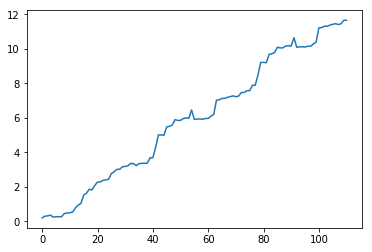

In [37]:
plt.plot(j)
plt.show()

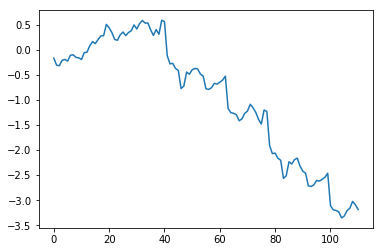

In [84]:
plt.plot(p)
plt.show()

In [67]:
math.log10((markov_jazz_1[song[0]+" "] * markov_jazz_1[song[1]+" "])/(not_markov_jazz_1[song[0]+" "]*not_markov_jazz_1[song[1]+" "]))

0.20621634898460872

In [68]:
not_markov_jazz_1[song[0]+" "]

0.04200152468111373

In [73]:
not_markov_jazz_1["once "]

0.04200152468111373

In [74]:
markov_jazz_1["once "]

0.06679440442117983